In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from typing import *

## 1. Dataset

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch_geometric.data import DataLoader, Data
# from torch_geometric.data.batch import DataBatch
from torch_geometric.utils import dense_to_sparse

from Bio.PDB import PDBParser
import os

In [6]:
def save_c_alpha_coords(pdb_file_path, npz_file_path):
    # Create a PDBParser object
    pdb_parser = PDBParser()

    # Parse the structure from your PDB file
    structure = pdb_parser.get_structure('my_structure', pdb_file_path)

    # Initialize a list to hold the C-alpha coordinates
    c_alpha_coords = []

    # Iterate through the model in the structure (assuming only one model)
    for model in structure:
        # Iterate through each chain in the model
        for chain in model:
            # Iterate through each residue in the chain
            for residue in chain:
                # Check if the residue has a C-alpha atom
                if 'CA' in residue:
                    # Get the coordinates of the C-alpha atom and append them to our list
                    c_alpha_coords.append(residue['CA'].get_coord())

    # Convert our list to a numpy array
    c_alpha_coords_np = np.array(c_alpha_coords)

    # Save the numpy array to a .npz file
    np.savez(npz_file_path, c_alpha_coords=c_alpha_coords_np)

In [9]:
save_c_alpha_coords("2wfu.pdb", "2wfu.npz")

/rds/user/ked48/hpc-work/protein-diffusion/venv_gpu/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 735.
  warnings.warn(
/rds/user/ked48/hpc-work/protein-diffusion/venv_gpu/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 751.
  warnings.warn(


In [12]:
data_path = os.getcwd() + "/2wfu.npz"


SCALE_FACTOR = 20. # Transform the coordinates from Angstroms to nanometers

def positions_to_graph(x, position_scale_factor: float = SCALE_FACTOR):
    # Convert the sample to a torch Tensor
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).to(torch.float32) 

    x = x / SCALE_FACTOR
    # Center the coordinates
    x = x - x.mean(dim=0)

    N = x.shape[0]
    # Create the fully connected adjacency matrix
    adj_matrix = torch.ones((N, N)) - torch.eye(N)

    # Convert the adjacency matrix to sparse edge indices
    edge_index = dense_to_sparse(adj_matrix)[0]

    # Add a chain order index to the node features
    chain_order = torch.arange(N)

    # Create a torch_geometric.data.Data object
    data = Data(pos=x, edge_index=edge_index, order=chain_order)
    return data


class NpzDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path)
        self.keys = list(self.data.keys())  # Assuming each key represents a different sample

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        key = self.keys[index]
        sample = self.data[key]
        # Perform any necessary preprocessing or transformations on the sample

        data = positions_to_graph(sample)
        data.id = key

        # Return the preprocessed sample and its corresponding label (if available)
        return data

# Create an instance of the NpzDataset
dataset = NpzDataset(data_path)

# Create a PyTorch DataLoader
batch_size = 16  # Adjust this value according to your needs
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


/rds/user/ked48/hpc-work/protein-diffusion/venv_gpu/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [15]:
from evaluation.visualize import plot_pointcloud
import matplotlib.pyplot as plt

sample = dataset[346]
plot_pointcloud(sample.pos.numpy())
plt.plot(*[sample.pos[:, i].numpy() for i in range(3)], c='k', alpha=0.5);

ModuleNotFoundError: No module named 'evaluation'

## 2. Chroma chain covariance

In [569]:
import numpy as np


a = 0.3
b = 1.0
xi = 0.9

def R_center(xi, N):
    return np.eye(N) - (xi / N) * np.ones((N, N))

def R_sum(b, N):
    # Matrix with ones in diagonal, twos in off-diagonal 1, three in off-diagonal 2, etc.
    R = np.eye(N)
    for i in range(1, N):
        R += np.diag(b ** (np.ones(N - i)* i), k=-i)
    return R

def R_init(b, N):
    R = np.diag(np.ones(N))
    R[0,0] = 1. / np.sqrt(1.-b**2 + 1e-4)
    return R

def R(N: int, *, a: float = 0.3, b: float = 1.0, xi: float = 0.9):
    return a * R_center(xi, N) @ R_sum(b, N) #@ R_init(b, N)  # NOTE: exluded R_init bc of numerical issues

## 3. SDE model

In [570]:
from utils.torch_utils import inflate_batch_array

In [571]:
"""Abstract SDE classes, Reverse SDE, and VE/VP SDEs.
From: https://github.com/yang-song/score_sde_pytorch/blob/main/sde_lib.py
"""
import abc
import torch
import numpy as np

# NOTE: The SDE essentially corresponds to the combination of (schedule, noise_type) 
#  in the `ddpm` picture. 
class SDE(abc.ABC):
  """SDE abstract class. Functions are designed for a mini-batch of inputs."""

  def __init__(self, N):
    """Construct an SDE.

    Args:
      N: number of discretization time steps.
    """
    super().__init__()
    self.N = N

  @property
  @abc.abstractmethod
  def T(self):
    """End time of the SDE."""
    pass

  @abc.abstractmethod
  def sde(self, x, t):
    pass

  @abc.abstractmethod
  def marginal_prob(self, x, t):
    """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
    pass

  @abc.abstractmethod
  def prior_sampling(self, shape):
    """Generate one sample from the prior distribution, $p_T(x)$."""
    pass

  @abc.abstractmethod
  def prior_logp(self, z):
    """Compute log-density of the prior distribution.

    Useful for computing the log-likelihood via probability flow ODE.

    Args:
      z: latent code
    Returns:
      log probability density
    """
    pass

  def discretize(self, x, t):
    """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

    Useful for reverse diffusion sampling and probabiliy flow sampling.
    Defaults to Euler-Maruyama discretization.

    Args:
      x: a torch tensor
      t: a torch float representing the time step (from 0 to `self.T`)

    Returns:
      f, G
    """
    dt = 1 / self.N
    drift, diffusion = self.sde(x, t)
    f = drift * dt
    G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
    return f, G

  def reverse(self, score_fn, probability_flow=False):
    """Create the reverse-time SDE/ODE.

    Args:
      score_fn: A time-dependent score-based model that takes x and t and returns the score.
      probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
    """
    N = self.N
    T = self.T
    sde_fn = self.sde
    discretize_fn = self.discretize

    # Build the class for reverse-time SDE.
    class RSDE(self.__class__):
      def __init__(self):
        self.N = N
        self.probability_flow = probability_flow

      @property
      def T(self):
        return T

      def sde(self, x, t):
        """Create the drift and diffusion functions for the reverse SDE/ODE."""
        drift, diffusion = sde_fn(x, t)
        score = score_fn(x, t)
        drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
        # Set the diffusion function to zero for ODEs.
        diffusion = 0. if self.probability_flow else diffusion
        return drift, diffusion

      def discretize(self, x, t):
        """Create discretized iteration rules for the reverse diffusion sampler."""
        f, G = discretize_fn(x, t)
        rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
        rev_G = torch.zeros_like(G) if self.probability_flow else G
        return rev_f, rev_G

    return RSDE()

In [572]:
class VPSDE(SDE):
  def __init__(self, beta_min=0.1, beta_max=20, N=1000):
    """Construct a Variance Preserving SDE.

    Args:
      beta_min: value of beta(0)
      beta_max: value of beta(1)
      N: number of discretization steps
    """
    super().__init__(N)
    self.beta_0 = beta_min
    self.beta_1 = beta_max
    self.N = N
    self.discrete_betas = torch.linspace(beta_min / N, beta_max / N, N)
    self.alphas = 1. - self.discrete_betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
    self.sqrt_1m_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

  @property
  def T(self):
    return 1

  def sde(self, x, t):
    beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
    drift = -0.5 * beta_t[:, None, None, None] * x
    diffusion = torch.sqrt(beta_t)
    return drift, diffusion

  def marginal_prob(self, x, t):
    log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
    mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
    return mean, std

  def prior_sampling(self, shape):
    return torch.randn(*shape)

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.
    return logps

  def discretize(self, x, t):
    """DDPM discretization."""
    timestep = (t * (self.N - 1) / self.T).long()
    beta = self.discrete_betas.to(x.device)[timestep]
    alpha = self.alphas.to(x.device)[timestep]
    sqrt_beta = torch.sqrt(beta)
    f = torch.sqrt(alpha)[:, None, None, None] * x - x
    G = sqrt_beta
    return f, G

In [591]:
from loguru import logger
from functools import partial, cached_property, lru_cache

def R(N: int, *, a: float = 0.3, b: float = 1.0, xi: float = 0.9):
    return a * R_center(xi, N) @ R_sum(b, N) #@ R_init(b, N)  # NOTE: exluded R_init bc of numerical issues

Rfunc = partial(R, a=0.3, b=1.0, xi=0.9)

class DewhitenedVPGraphSDE(VPSDE):
  
  def __init__(self, *, R_func, Rinv_func = None, beta_min=0.1, beta_max=20, N=1000):
    super().__init__(beta_min, beta_max, N)
    self.R_func = R_func
    self.Rinv_func = Rinv_func

  @lru_cache(maxsize=3000)
  def R(self, N: int) -> torch.Tensor:
    R = self.R_func(N)
    largest_abs_val = np.max(np.abs(R))
    if largest_abs_val > 1e3:
      logger.warning(f"R has large values: max: {largest_abs_val}")
    if isinstance(R, np.ndarray):
      R = torch.from_numpy(R).to(torch.float32)
    return R

  @lru_cache(maxsize=3000)
  def Rinv(self, N: int) -> torch.Tensor:
    if self.Rinv_func is None:
      Rinv = torch.linalg.pinv(self.R(N), atol=1e-8)
    
    # Sanity checks
    largest_abs_val = Rinv.abs().max()
    if largest_abs_val > 1e3:
      logger.warning(f"Rinv has large values: max: {largest_abs_val}")
    largest_deviation = (self.R(N) @ Rinv - torch.eye(N, dtype=Rinv.dtype)).abs().max()
    if largest_deviation > 1e-3:
      logger.warning(f"Rinv is not close to inverse: max deviation: {largest_deviation}")
    
    return Rinv

  @lru_cache(maxsize=3000)
  def RRT(self, N: int) -> torch.Tensor:
    R = self.R(N)
    RRT = R @ R.T

    # Sanity checks
    largest_abs_val = RRT.abs().max()
    if largest_abs_val > 1e3:
      logger.warning(f"RRT has large values: max: {largest_abs_val}")

    return RRT

  def dewhiten(self, z: torch.Tensor) -> torch.Tensor:
    # z: [n_nodes, n_dim] or [batch_size, n_nodes, n_dim] (white noise)
    if z.ndim == 2:
      is_batched = False
      z = z[None, ...]  # [1, n_nodes, n_dim]
    else:
      is_batched = True

    n_nodes = z.shape[1]
    z = torch.einsum("nm,bmd->bnd", self.Rinv(n_nodes), z)  # [batch_size, n_nodes, n_dim]
    return z if is_batched else z[0, ...]  # [n_nodes, n_dim] or [batch_size, n_nodes, n_dim]

  def whiten(self, x: torch.Tensor) -> torch.Tensor:
    # x: [n_nodes, n_dim] or [batch_size, n_nodes, n_dim] (correlated noise)
    if x.ndim == 2:
      is_batched = False
      x = x[None, ...]  # [1, n_nodes, n_dim]
    else:
      is_batched = True

    n_nodes = x.shape[1]
    x = torch.einsum("nm,bmd->bnd", self.Rinv(n_nodes), x)  # [batch_size, n_nodes, n_dim]
    return x if is_batched else x[0, ...]  # [n_nodes, n_dim] or [batch_size, n_nodes, n_dim]

  def marginal_prob(self, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Parameters to determine the marginal distribution of the SDE, $p_{0t}(x(t)|x(0))$.

    NOTE: 
      For a VP SDE, the marginal distribution is a Gaussian of the following form:
      $p_{0t}(x(t)|x(0)) = \mathcal{N}(x(t); \mu_t x(0), \sigma_t^2 I)$

      This function returns the parameters $\mu_t$ and $\sigma_t$.

      Used for the forward noising process.
    
    Args:
      t (torch.Tensor): time (scalar or vector).

    Returns:
      mean_scale (torch.Tensor): scaling factor $\mu_t$ for the mean of $p_t(x)$
      std_scale (torch.Tensor): scaling factor $\sigma_t$ for the standard deviation of $p_t(x)$
    """
    # t: [batch_size]
    log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
    mean = torch.exp(log_mean_coeff)  # [batch_size]
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))  # [batch_size]
    return mean, std

  @staticmethod
  def _match_to_graph_batch(quantity: torch.Tensor, batch, feature: str = "pos"):
    """Match the shape of a quantity to the batch shape of a batch of graphs."""
    # quantity: [batch_size]
    # batch[feature]: [n_nodes_batch, ...]
    assert quantity.shape[0] == batch.num_graphs
    quantity = quantity[batch.batch]  # [n_nodes_batch]
    quantity = inflate_batch_array(quantity, batch[feature])  # [n_nodes_batch, 1, ... 1]
    return quantity  # [n_nodes_batch, 1, ... 1]

  def sde(self, x: Data, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # t: [batch_size]
    # x.pos: [n_nodes_batch, n_nodes, n_dim]

    beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)  # [batch_size]
    # For graph case:
    beta_t = self._match_to_graph_batch(beta_t, x.pos)  # [n_nodes_batch, 1]

    drift = -0.5 * beta_t * x.pos  # [n_nodes_batch, n_nodes, n_dim]
    diffusion = torch.sqrt(self.beta_t)  # [n_nodes_batch, n_nodes, n_dim]
    # TODO: Think about whether to make these scalar: drift_scale, diffusion_scale
    return drift, diffusion

  def prior_sampling(self, shape: Tuple[int, int]) -> torch.Tensor:
    """Sample from the prior distribution, $p_0(x)$."""
    assert len(shape) == 3, "Shape must be (n_samples, n_nodes, n_dim)"
    n_samples, n_nodes, n_dim = shape

    # Sample white noise
    z = torch.randn(n_samples, n_nodes, n_dim)

    # Dewhitening
    x = torch.einsum("nm,bmd->bnd", self.R(n_nodes), z)  # [n_samples, n_nodes, n_dim]

    # Centering
    x = x - x.mean(dim=1, keepdim=True)  # [n_samples, n_nodes, n_dim]

    # Transform to DataBatch
    batch = DataBatch.from_data_list([positions_to_graph(g, position_scale_factor=1.) for g in x])
    batch.id = torch.arange(n_samples)

    return batch

  def discretize(self, x, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """DDPM discretization.
    Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

    Useful for reverse diffusion sampling and probabiliy flow sampling.
    Defaults to Euler-Maruyama discretization.

    Args:
      x (DataBatch): batch of graphs with node positions in `x.pos`
      t (torch.Tensor): time (scalar or vector)

    Returns:
      f (torch.Tensor): drift term
      G (torch.Tensor): diffusion term
    """
    timestep = (t * (self.N - 1) / self.T).long()
    beta = self.discrete_betas.to(x.device)[timestep]
    alpha = self.alphas.to(x.device)[timestep]
    sqrt_beta = torch.sqrt(beta)
    # For graph case:
    f = self._match_to_graph_batch(alpha.sqrt(), x) * x.pos - x.pos  # [n_nodes_batch, n_dim]
    #f = torch.sqrt(alpha)[:, None, None, None] * x - x  # TODO fix
    G = sqrt_beta
    return f, G

  def prior_logp(self, z: torch.Tensor):
    raise NotImplementedError()

  def noise_like(self, batch, dewhiten: bool=True) -> torch.Tensor:

    # For graph batching case:
    noise = torch.zeros_like(batch.pos)  # [n_nodes_batch, n_dim]
    for graph, (ptr0, ptr1) in enumerate(zip(batch.ptr[:-1], batch.ptr[1:])):
      n_nodes = ptr1 - ptr0
      # White noise
      z = torch.randn(n_nodes, noise.shape[1])  # [n_nodes, n_dim]
      # Dewhitening
      if dewhiten:
        z = self.dewhiten(z)  # [n_nodes, n_dim]
      # Subtracting center of mass
      z -= z.mean(dim=0, keepdim=True)  # [n_nodes, n_dim]
      noise[ptr0:ptr1] = z

    # For dim batching case:
    # noise = torch.randn(batch.pos.shape)  # [batch_size, n_nodes, n_dim]
    # Dewhitening
    # if dewhiten:
    #   n_nodes = batch.pos.shape[1]
    #   noise = torch.einsum("nm,bmd->bnd", self.R(batch.pos.shape[1]), noise)  # [batch_size, n_nodes, n_dim]

    return noise  # [n_nodes_batch, n_dim]

  def noising(self, batch, t: torch.Tensor):
    mean_scale, std_scale = self.marginal_prob(t)  # [batch_size], [batch_size]

    # For graph case:
    mean_scale = self._match_to_graph_batch(mean_scale, batch, "pos")  # [n_nodes_batch, 1]
    std_scale = self._match_to_graph_batch(std_scale, batch, "pos")  # [n_nodes_batch, 1]

    batch.pos = mean_scale * batch.pos + std_scale * self.noise_like(batch, dewhiten=True)  # [n_nodes_batch, n_dim]
    return batch

  def reverse(self, score_fn, probability_flow=False):
    """Create the reverse-time SDE/ODE.

    Args:
      score_fn: A time-dependent score-based model that takes x and t and returns the score.
      probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
    """
    N = self.N
    T = self.T
    R_func = self.R_func
    Rinv_func = self.Rinv_func
    sde_fn = self.sde
    discretize_fn = self.discretize

    # Build the class for reverse-time SDE.
    class RSDE(self.__class__):
      def __init__(self):
        self.N = N
        self.probability_flow = probability_flow

      @property
      def T(self):
        return T

      def sde(self, x, t):
        """Create the drift and diffusion functions for the reverse SDE/ODE."""
        drift, diffusion = sde_fn(x, t)
        score = score_fn(x, t)
        drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
        # Set the diffusion function to zero for ODEs.
        diffusion = 0. if self.probability_flow else diffusion
        return drift, diffusion

      def discretize(self, x, t):
        """Create discretized iteration rules for the reverse diffusion sampler."""
        f, G = discretize_fn(x, t)
        rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
        rev_G = torch.zeros_like(G) if self.probability_flow else G
        return rev_f, rev_G

    return RSDE()
  

In [574]:
dsde = DewhitenedVPGraphSDE(R_func = Rfunc)

In [576]:
dsde.prior_sampling((3, 100, 3))

DataDataBatch(edge_index=[2, 29700], pos=[300, 3], order=[300], batch=[300], ptr=[4], id=[3])

### Training

### Sampling

In [ ]:
class Predictor(abc.ABC):
  """The abstract class for a predictor algorithm."""

  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__()
    self.sde = sde
    # Compute the reverse SDE/ODE
    self.rsde = sde.reverse(score_fn, probability_flow)
    self.score_fn = score_fn

  @abc.abstractmethod
  def update_fn(self, x, t):
    """One update of the predictor.

    Args:
      x: A PyTorch tensor representing the current state
      t: A Pytorch tensor representing the current time step.

    Returns:
      x: A PyTorch tensor of the next state.
      x_mean: A PyTorch tensor. The next state without random noise. Useful for denoising.
    """
    pass

class AncestralSamplingPredictor(Predictor):
  """The ancestral sampling predictor. Currently only supports Graph VP SDEs."""

  def __init__(self, sde, score_fn, probability_flow=False):
    super().__init__(sde, score_fn, probability_flow)
    assert not probability_flow, "Probability flow not supported by ancestral sampling"

  def vpsde_update_fn(self, x, t):
    sde = self.sde
    timestep = (t * (sde.N - 1) / sde.T).long()
    beta = sde.discrete_betas.to(t.device)[timestep]
    score = self.score_fn(x, t)
    x_mean = (x + beta[:, None, None, None] * score) / torch.sqrt(1. - beta)[:, None, None, None]
    noise = torch.randn_like(x)
    x = x_mean + torch.sqrt(beta)[:, None, None, None] * noise
    return x, x_mean

  def update_fn(self, x, t):
    if isinstance(self.sde, sde_lib.VESDE):
      return self.vesde_update_fn(x, t)
    elif isinstance(self.sde, sde_lib.VPSDE):
      return self.vpsde_update_fn(x, t)

In [ ]:
def get_pc_sampler(sde, shape, predictor, corrector, inverse_scaler, snr,
                   n_steps=1, probability_flow=False, continuous=False,
                   denoise=True, eps=1e-3, device='cuda'):
  """Create a Predictor-Corrector (PC) sampler.

  Args:
    sde: An `sde_lib.SDE` object representing the forward SDE.
    shape: A sequence of integers. The expected shape of a single sample.
    predictor: A subclass of `sampling.Predictor` representing the predictor algorithm.
    corrector: A subclass of `sampling.Corrector` representing the corrector algorithm.
    inverse_scaler: The inverse data normalizer.
    snr: A `float` number. The signal-to-noise ratio for configuring correctors.
    n_steps: An integer. The number of corrector steps per predictor update.
    probability_flow: If `True`, solve the reverse-time probability flow ODE when running the predictor.
    continuous: `True` indicates that the score model was continuously trained.
    denoise: If `True`, add one-step denoising to the final samples.
    eps: A `float` number. The reverse-time SDE and ODE are integrated to `epsilon` to avoid numerical issues.
    device: PyTorch device.

  Returns:
    A sampling function that returns samples and the number of function evaluations during sampling.
  """
  # Create predictor & corrector update functions
  predictor_update_fn = functools.partial(shared_predictor_update_fn,
                                          sde=sde,
                                          predictor=predictor,
                                          probability_flow=probability_flow,
                                          continuous=continuous)
  corrector_update_fn = functools.partial(shared_corrector_update_fn,
                                          sde=sde,
                                          corrector=corrector,
                                          continuous=continuous,
                                          snr=snr,
                                          n_steps=n_steps)

  def pc_sampler(model):
    """ The PC sampler funciton.

    Args:
      model: A score model.
    Returns:
      Samples, number of function evaluations.
    """
    with torch.no_grad():
      # Initial sample
      x = sde.prior_sampling(shape).to(device)
      timesteps = torch.linspace(sde.T, eps, sde.N, device=device)

      for i in range(sde.N):
        t = timesteps[i]
        vec_t = torch.ones(shape[0], device=t.device) * t
        x, x_mean = corrector_update_fn(x, vec_t, model=model)
        x, x_mean = predictor_update_fn(x, vec_t, model=model)

      return inverse_scaler(x_mean if denoise else x), sde.N * (n_steps + 1)

  return pc_sampler

In [589]:
dsde.noise_like?

Signature:
dsde.noise_like(
    batch: torch_geometric.data.batch.DataBatch,
    dewhiten: bool = True,
) -> torch.Tensor
Docstring: <no docstring>
File:      /tmp/ipykernel_699194/1119814511.py
Type:      method

In [606]:
device = "cpu"

with torch.no_grad():
    # Initial sample
    x = dsde.prior_sampling((10, 50, 3)).to(device)
    timesteps = torch.linspace(dsde.T, 1e-3, dsde.N, device=device)

    for i in range(dsde.N):
        t = timesteps[i]
        # TODO: Implement from here ==============================================
        # vec_t = torch.ones(10, device=t.device) * t
        # sample_batch, x_mean = corrector_update_fn(sample_batch, vec_t, model=model)  # I will use NoneCorrector
        # sample_batch, x_mean = predictor_update_fn(sample_batch, vec_t, model=model)

        # Ancestral Sampling
        sde = dsde
        timestep = (t * (sde.N - 1) / sde.T).long()
        beta = sde.discrete_betas.to(t.device)[timestep]
        #score = self.score_fn(x, t)  # TODO: Implement score function
        score = torch.randn_like(x.pos)
        # NOTE: No need to match to graph_batch because betas are scalars here.
        #x_mean = (x.pos + sde._match_to_graph_batch(beta, x) * score) / sde._match_to_graph_batch(torch.sqrt(1. - beta), x)
        x_mean = (x.pos + beta * score) / (1.-beta).sqrt()
        noise = sde.noise_like(x)
        #x.pos = x_mean + sde._match_to_graph_batch(beta.sqrt(), x) * noise
        x.pos = x_mean + beta.sqrt() * noise
        #return x, x_mean


        # TODO: Implement until here ==============================================

    # Inverse scale the positions
    x.pos = x.pos #* SCALE_FACTOR

In [611]:
(1.-beta).sqrt()

tensor(0.9999)

COM tensor([1.0710, 1.8723, 1.8799])


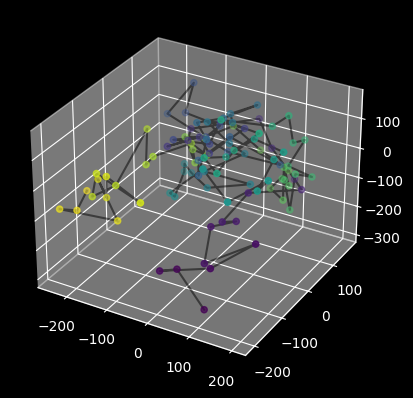

In [607]:
p(x.pos[:100])

---

## Misc tests

In [539]:
dsde.reverse(score_fn= lambda x: x).sde_fn(DataBatch.from_data_list([dataset[0]]), torch.tensor([0.0]))

AttributeError: 'RSDE' object has no attribute 'sde_fn'

COM tensor([-1.1315e-07,  2.1983e-06,  1.2123e-07])


/home/svm34/code/protein-dynamics/venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/svm34/code/protein-dynamics/venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

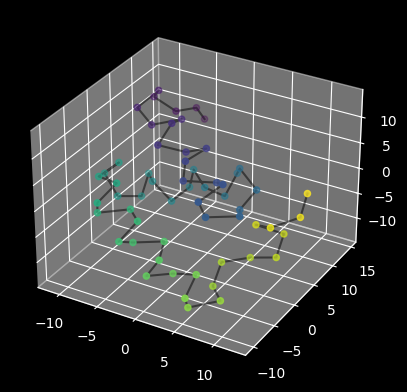

In [503]:
p(dataset[0].pos)

COM tensor([-1.1315e-07,  2.0205e-06,  1.2931e-07])


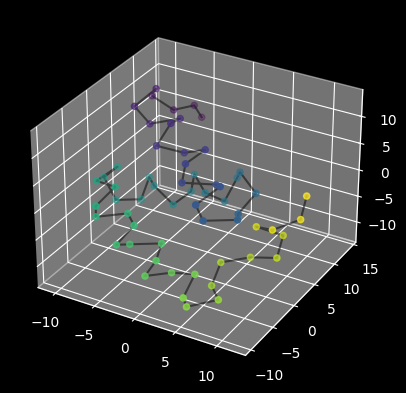

In [508]:
p(dsde.noising(DataBatch.from_data_list([dataset[0]]), torch.Tensor([.1])).pos)

COM tensor([ 1.2123e-08,  6.0615e-09, -9.0922e-09])


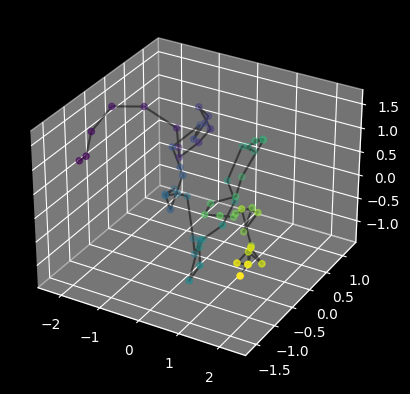

In [507]:
p(dsde.noise_like(DataBatch.from_data_list([dataset[0]])))

COM tensor([-0.0535, -0.0818,  0.0088])


/home/svm34/code/protein-dynamics/venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/svm34/code/protein-dynamics/venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

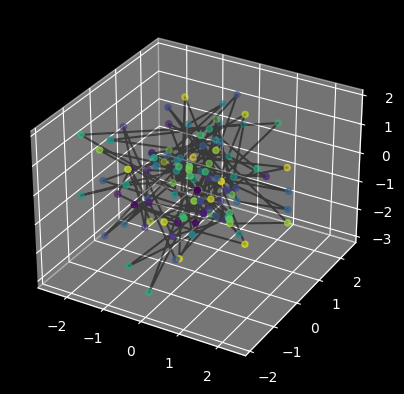

In [453]:
p(z)

COM tensor([-0.1330, -0.2890,  0.0649])


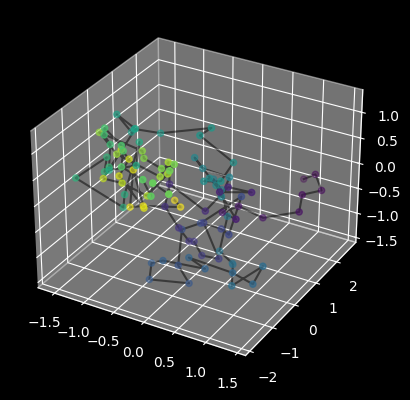

In [454]:
p(dsde.dewhiten(z))

Chroma reverse SDE:

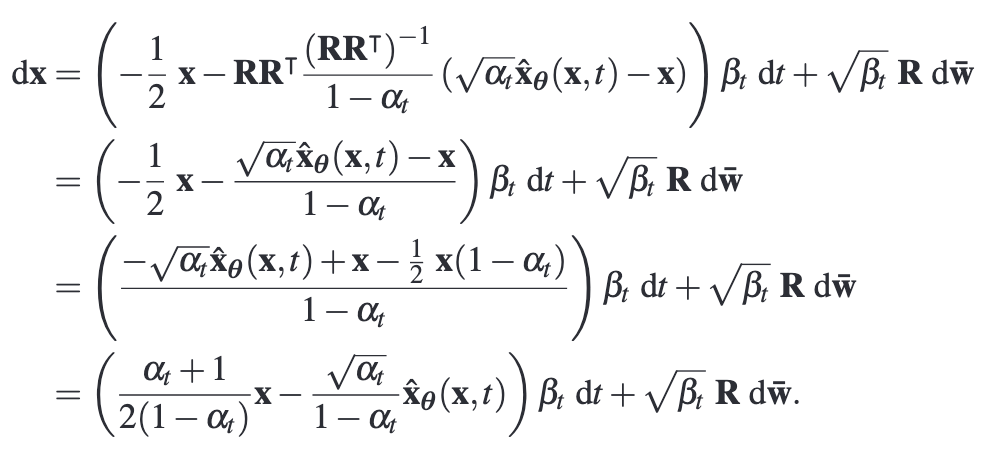

In [18]:
class ContinuousNoiseSchedule(torch.nn.Module, abc.ABC):
    """Base class for continuous noise schedules."""
    
    @abc.abstractmethod
    def alpha(self, t):
        """Returns the value of alpha at time t, where t is in [0, T]."""
        pass
    
    @abc.abstractmethod
    def beta(self, t):
        """Returns the value of beta at time t, where t is in [0, T]."""
        pass
    
    def plot(self):
        t = torch.linspace(0, 1, 1000)
        #plt.plot(t, self.beta(t), label=r"$\beta(t)$", marker=".")
        plt.plot(t, self.alpha(t), label=r"$\alpha(t)$", marker=".")
        plt.plot(
            t,
            self.alpha(t).sqrt(),
            label=r"$\sqrt{\alpha_t}$",
            color="C0",
            alpha=0.2,
            linestyle="--",
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.grid(linestyle="--", alpha=0.1)
        plt.xlabel(r"Step $t$")

In [53]:
class LinearSchedule(ContinuousNoiseSchedule):
    def __init__(self, beta_0: float = 1e-4, beta_T: float = 2e-2):
        self.beta_0 = beta_0
        self.beta_T = beta_T
    
    def beta(self, t):
        return self.beta_0 + (self.beta_T - self.beta_0) * t

    def alpha(self, t):
        # # From CHROMA
        # denom = self.beta_0 - self.beta_T
        # numer = torch.exp(-self.beta_0 - self.beta_T * t) * (torch.exp(self.beta_0 * t) - torch.exp(self.beta_T * t))
        # return (1 - numer / denom).sqrt()

        # From SONG? 
        # Integral of beta(t) from 0 to t
        #log_alpha = self.beta_0 * t + (self.beta_T - self.beta_0) * t ** 2 / 2.
        #return torch.exp(log_alpha)

        # random?
        # log_mean_coeff = -0.25 * t ** 2 * (self.beta_T - self.beta_0) - 0.5 * t * self.beta_0
        # return torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        log_mean_coeff = -0.25 * t ** 2 * (self.beta_T - self.beta_0) - 0.5 * t * self.beta_0
        mean = torch.exp(log_mean_coeff)
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return mean ** 2

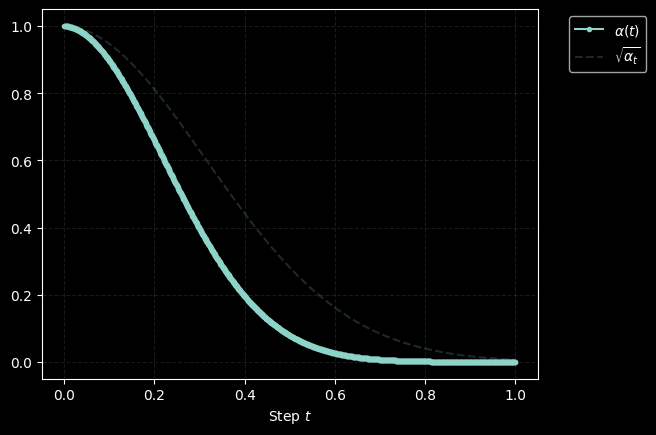

In [54]:
LinearSchedule(beta_0 = 0.1, beta_T=20.).plot()

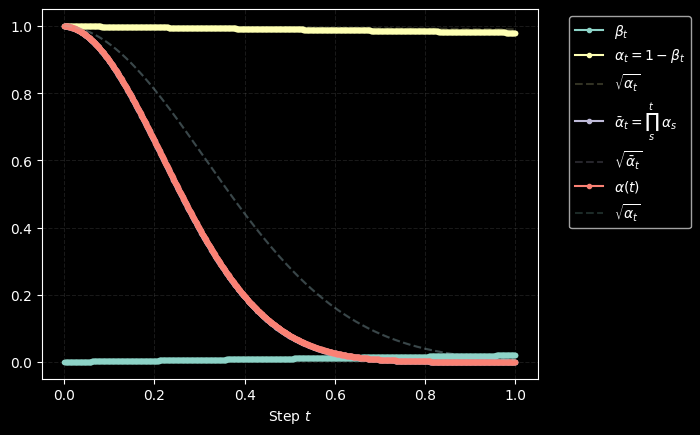

In [56]:
from diffusion.schedule import LinearSchedule as DiscreteLinearSchedule
DiscreteLinearSchedule(beta_start=0.1 / 1000, beta_end=20. / 1000, n_steps=1000).plot(t=torch.linspace(0, 1, 1000))
#DiscreteLinearSchedule(beta_start=0.1 / 300, beta_end=20. / 300, n_steps=300).plot(t=torch.linspace(0, 1, 300))
#DiscreteLinearSchedule(beta_start=0.1 / 100, beta_end=20. / 100, n_steps=100).plot(t=torch.linspace(0, 1, 100))
LinearSchedule(beta_0 = 0.1, beta_T=20.).plot()